In [ ]:
# !pip install reportlab

  Pattern_Name  Hole_id  Drillhole_X  Drillhole_Y  Drillhole_Z  \
0   C1_340_102        1    429273.80   5266303.10       352.69   
1   C1_340_102        2    429278.40   5266305.26       352.26   
2   C1_340_102        3    429282.98   5266307.93       352.29   
3   C1_340_102        4    429287.55   5266310.60       352.25   
4   C1_340_102        5    429292.13   5266313.28       352.27   

   Drillhole_ToeX  Drillhole_ToeY  Drillhole_ToeZ  Drillhole_Length  \
0       429273.80      5266303.10           338.8             13.89   
1       429278.40      5266305.26           338.8             13.46   
2       429282.98      5266307.93           338.8             13.49   
3       429287.55      5266310.60           338.8             13.45   
4       429292.13      5266313.28           338.8             13.47   

   Drillhole_Dip  Drillhole_Azimuth  Avg_Displacement  Max_Displacement  \
0            -90                  0            2.5774            5.1548   
1            -90          

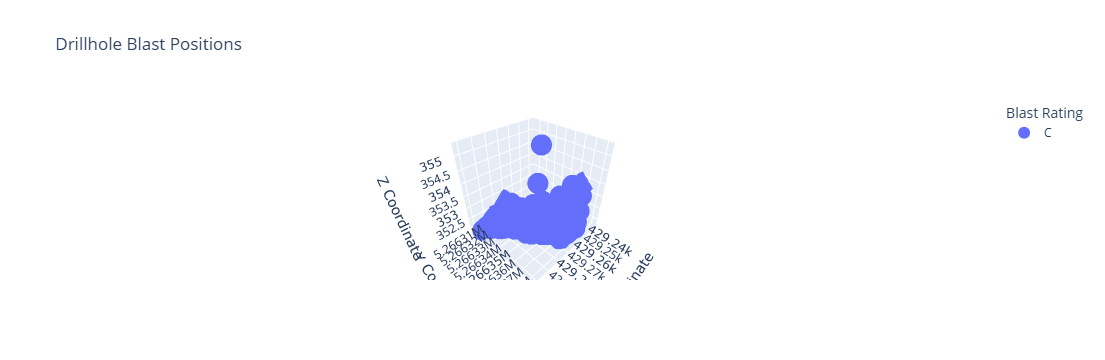

In [3]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px
import plotly.io as pio
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
import threading

# Global variable to store the dataset
df = None

# Function to load multiple CSV data
def load_multiple_csv(files):
    global df
    data_list = []
    for file in files:
        data = pd.read_csv(file)
        data_list.append(data)
    df = pd.concat(data_list, ignore_index=True)
    print(df.head())
    return df

# Train model using real-world data from multiple CSV files
def train_model(files):
    data = load_multiple_csv(files)
    
    features = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_ToeX", "Drillhole_ToeY", "Drillhole_ToeZ",
                "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Avg_Displacement", "Max_Displacement",
                "Centroid_Shift", "Earliest_Pixel_Disp", "PPV", "Overpressure", "Total_Displacement"]
    
    missing_columns = [col for col in features if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in the dataset: {', '.join(missing_columns)}")
    
    # Ensure the 'Blast_Rating' column contains only 'A', 'B', or 'C' categories
    label_encoder = LabelEncoder()
    data["Blast_Rating"] = label_encoder.fit_transform(data["Blast_Rating"])
    
    X = data[features]
    y = data["Blast_Rating"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, class_report, model, scaler, label_encoder, list(X.columns)

# Function to predict the rating for new data
def predict_rating(model, scaler, label_encoder, new_data, feature_columns):
    new_data_df = pd.DataFrame(new_data, columns=feature_columns)
    new_data_scaled = scaler.transform(new_data_df)
    predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
    return predicted_rating[0]

# Function to save the 3D scatter plot as a PDF
def save_pdf(fig):
    # Save the plot as PNG first
    pio.write_image(fig, "scatter_plot.png")

    # Create PDF and embed the PNG
    pdf_path = "C:/Downloads/"
    c = canvas.Canvas(pdf_path, pagesize=letter)
    c.drawString(100, 750, "3D Scatter Plot")

    # Adding the image to the PDF (resize for better memory efficiency)
    c.drawImage("scatter_plot.png", 50, 400, width=400, height=300)  # Resize image to reduce memory use
    c.save()

    # Inform the user that the PDF has been saved
    messagebox.showinfo("PDF Saved", f"PDF saved successfully as {pdf_path}")

# Function to run PDF saving in a separate thread
def save_pdf_in_background(fig):
    thread = threading.Thread(target=save_pdf, args=(fig,))
    thread.start()

# UI setup
def create_ui():
    global df  # Ensure you can access the df variable globally for the plot
    
    root = tk.Tk()
    root.title("Blast Rating Prediction")
    root.geometry("600x600")

    model, scaler, label_encoder, feature_columns = None, None, None, None

    def load_files():
        nonlocal model, scaler, label_encoder, feature_columns
        files = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if files:
            accuracy, class_report, model, scaler, label_encoder, feature_columns = train_model(files)
            
            accuracy_label.config(text=f"Accuracy: {accuracy:.4f}")

            class_report_text.delete(1.0, tk.END)
            class_report_text.insert(tk.END, class_report)
            
            prediction_section.pack()

            # Plot the 3D scatter plot after loading data
            if df is not None:
                # Map the numeric 'Blast_Rating' back to categories 'A', 'B', 'C' for visualization
                df['Blast_Rating_Label'] = label_encoder.inverse_transform(df['Blast_Rating'])
                
                fig = px.scatter_3d(df, x='Drillhole_X', y='Drillhole_Y', z='Drillhole_Z', color='Blast_Rating_Label', 
                                    labels={'Blast_Rating_Label': 'Blast Rating', 'Drillhole_X': 'X Coordinate', 
                                            'Drillhole_Y': 'Y Coordinate', 'Drillhole_Z': 'Z Coordinate'},
                                    title="Drillhole Blast Positions")
                fig.update_traces(marker=dict(size=12))
                fig.show()

                # Save plot to PDF in the background
                save_pdf_in_background(fig)

    load_files_button = tk.Button(root, text="Load CSV Files", command=load_files)
    load_files_button.pack(pady=10)

    accuracy_label = tk.Label(root, text="Accuracy: ", font=("Arial", 12))
    accuracy_label.pack(pady=10)

    class_report_label = tk.Label(root, text="Classification Report:", font=("Arial", 12))
    class_report_label.pack(pady=10)

    class_report_text = tk.Text(root, height=10, width=70)
    class_report_text.pack(pady=10)

    prediction_section = tk.Frame(root)
    new_data_label = tk.Label(prediction_section, text="Enter new drillhole data (X, Y, Z, ToeX, ToeY, ToeZ, Length, Dip, Azimuth, Avg Displacement, Max Displacement, Centroid Shift, Earliest Pixel Disp, PPV, Overpressure, Total Displacement):", font=("Arial", 12))
    new_data_label.pack(pady=10)

    # Entry fields for prediction data
    entry_x = tk.Entry(prediction_section, width=10)
    entry_x.pack(pady=5)
    entry_x.insert(0, "250")

    entry_y = tk.Entry(prediction_section, width=10)
    entry_y.pack(pady=5)
    entry_y.insert(0, "250")

    entry_z = tk.Entry(prediction_section, width=10)
    entry_z.pack(pady=5)
    entry_z.insert(0, "150")

    entry_toex = tk.Entry(prediction_section, width=10)
    entry_toex.pack(pady=5)
    entry_toex.insert(0, "245")

    entry_toey = tk.Entry(prediction_section, width=10)
    entry_toey.pack(pady=5)
    entry_toey.insert(0, "245")

    entry_toez = tk.Entry(prediction_section, width=10)
    entry_toez.pack(pady=5)
    entry_toez.insert(0, "148")

    entry_length = tk.Entry(prediction_section, width=10)
    entry_length.pack(pady=5)
    entry_length.insert(0, "120")

    entry_dip = tk.Entry(prediction_section, width=10)
    entry_dip.pack(pady=5)
    entry_dip.insert(0, "40")

    entry_azimuth = tk.Entry(prediction_section, width=10)
    entry_azimuth.pack(pady=5)
    entry_azimuth.insert(0, "180")

    entry_avg_disp = tk.Entry(prediction_section, width=10)
    entry_avg_disp.pack(pady=5)
    entry_avg_disp.insert(0, "2")

    entry_max_disp = tk.Entry(prediction_section, width=10)
    entry_max_disp.pack(pady=5)
    entry_max_disp.insert(0, "8")

    entry_centroid_shift = tk.Entry(prediction_section, width=10)
    entry_centroid_shift.pack(pady=5)
    entry_centroid_shift.insert(0, "1")

    entry_earliest_pixel_disp = tk.Entry(prediction_section, width=10)
    entry_earliest_pixel_disp.pack(pady=5)
    entry_earliest_pixel_disp.insert(0, "2")

    entry_ppv = tk.Entry(prediction_section, width=10)
    entry_ppv.pack(pady=5)
    entry_ppv.insert(0, "5")

    entry_overpressure = tk.Entry(prediction_section, width=10)
    entry_overpressure.pack(pady=5)
    entry_overpressure.insert(0, "50")

    entry_total_disp = tk.Entry(prediction_section, width=10)
    entry_total_disp.pack(pady=5)
    entry_total_disp.insert(0, "15")

    def on_predict():
        try:
            new_data = np.array([[float(entry_x.get()), float(entry_y.get()), float(entry_z.get()), 
                                  float(entry_toex.get()), float(entry_toey.get()), float(entry_toez.get()), 
                                  float(entry_length.get()), float(entry_dip.get()), float(entry_azimuth.get()),
                                  float(entry_avg_disp.get()), float(entry_max_disp.get()), float(entry_centroid_shift.get()),
                                  float(entry_earliest_pixel_disp.get()), float(entry_ppv.get()), float(entry_overpressure.get()),
                                  float(entry_total_disp.get())]])
            predicted_rating = predict_rating(model, scaler, label_encoder, new_data, feature_columns)
            result_label.config(text=f"Predicted Rating: {predicted_rating}")  # Show predicted rating as A, B, or C
        except Exception as e:
            messagebox.showerror("Error", f"Failed to make prediction: {e}")

    predict_button = tk.Button(prediction_section, text="Predict Rating", command=on_predict)
    predict_button.pack(pady=10)

    result_label = tk.Label(prediction_section, text="Predicted Rating: ", font=("Arial", 14))
    result_label.pack(pady=10)

    root.mainloop()

# Run the UI
create_ui()

  Pattern_Name Hole_id  Drillhole_X  Drillhole_Y  Drillhole_Z  Drillhole_ToeX  \
0   C1_352_108      33    429696.61   5266456.29       363.51       429696.61   
1   C1_352_108      34    429693.97   5266462.06       363.55       429693.97   
2   C1_352_108      35    429691.33   5266467.82       363.67       429691.33   
3   C1_352_108      36    429688.70   5266473.58       363.54       429688.70   
4   C1_352_108      37    429694.97   5266473.01       363.71       429694.97   

   Drillhole_ToeY  Drillhole_ToeZ  Drillhole_Length  Drillhole_Dip  \
0      5266456.29           350.8             12.71            -90   
1      5266462.06           350.8             12.75            -90   
2      5266467.82           350.8             12.87            -90   
3      5266473.58           350.8             12.74            -90   
4      5266473.01           350.8             12.91            -90   

   Drillhole_Azimuth  Avg_Displacement  Max_Displacement  Centroid_Shift  \
0               

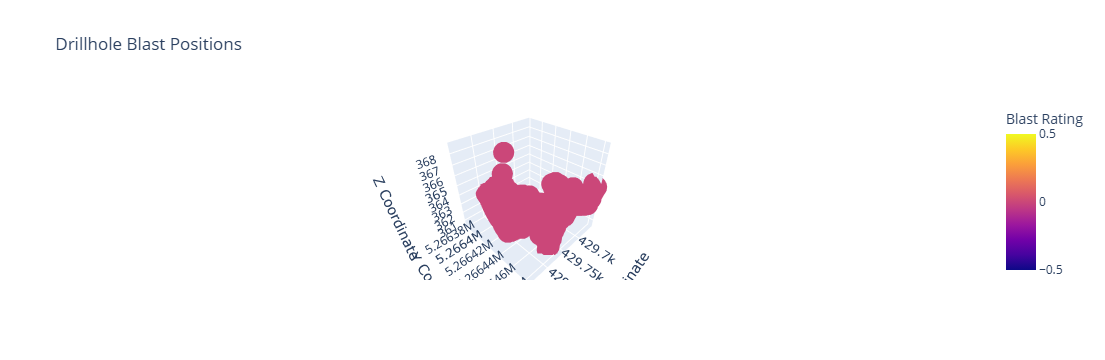

In [5]:
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import plotly.express as px

# Global variable to store the dataset
df = None

# Function to load multiple CSV data
def load_multiple_csv(files):
    global df
    data_list = []
    for file in files:
        data = pd.read_csv(file)
        data_list.append(data)
    df = pd.concat(data_list, ignore_index=True)
    print(df.head())
    return df

# Train model using real-world data from multiple CSV files
def train_model(files):
    data = load_multiple_csv(files)
    
    features = ["Drillhole_X", "Drillhole_Y", "Drillhole_Z", "Drillhole_ToeX", "Drillhole_ToeY", "Drillhole_ToeZ",
                "Drillhole_Length", "Drillhole_Dip", "Drillhole_Azimuth", "Avg_Displacement", "Max_Displacement",
                "Centroid_Shift", "Earliest_Pixel_Disp", "PPV", "Overpressure", "Total_Displacement"]
    
    missing_columns = [col for col in features if col not in data.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in the dataset: {', '.join(missing_columns)}")
    
    label_encoder = LabelEncoder()
    data["Blast_Rating"] = label_encoder.fit_transform(data["Blast_Rating"])
    
    X = data[features]
    y = data["Blast_Rating"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

    return accuracy, class_report, model, scaler, label_encoder, list(X.columns)

# Function to predict the rating for new data
def predict_rating(model, scaler, label_encoder, new_data, feature_columns):
    new_data_df = pd.DataFrame(new_data, columns=feature_columns)
    new_data_scaled = scaler.transform(new_data_df)
    predicted_rating = label_encoder.inverse_transform(model.predict(new_data_scaled))
    return predicted_rating[0]

# UI setup
def create_ui():
    global df  # Ensure you can access the df variable globally for the plot
    
    root = tk.Tk()
    root.title("Blast Rating Prediction")
    root.geometry("600x600")

    model, scaler, label_encoder, feature_columns = None, None, None, None

    def load_files():
        nonlocal model, scaler, label_encoder, feature_columns
        files = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if files:
            accuracy, class_report, model, scaler, label_encoder, feature_columns = train_model(files)
            
            accuracy_label.config(text=f"Accuracy: {accuracy:.4f}")

            class_report_text.delete(1.0, tk.END)
            class_report_text.insert(tk.END, class_report)
            
            prediction_section.pack()

            # Plot the 3D scatter plot after loading data
            if df is not None:
                fig = px.scatter_3d(df, x='Drillhole_X', y='Drillhole_Y', z='Drillhole_Z', color='Blast_Rating', 
                                    labels={'Blast_Rating': 'Blast Rating', 'Drillhole_X': 'X Coordinate', 'Drillhole_Y': 'Y Coordinate', 'Drillhole_Z': 'Z Coordinate'},
                                    title="Drillhole Blast Positions")
                fig.update_traces(marker=dict(size=12))
                fig.show()

    load_files_button = tk.Button(root, text="Load CSV Files", command=load_files)
    load_files_button.pack(pady=10)

    accuracy_label = tk.Label(root, text="Accuracy: ", font=("Arial", 12))
    accuracy_label.pack(pady=10)

    class_report_label = tk.Label(root, text="Classification Report:", font=("Arial", 12))
    class_report_label.pack(pady=10)

    class_report_text = tk.Text(root, height=10, width=70)
    class_report_text.pack(pady=10)

    prediction_section = tk.Frame(root)
    new_data_label = tk.Label(prediction_section, text="Enter new drillhole data (X, Y, Z, ToeX, ToeY, ToeZ, Length, Dip, Azimuth, Avg Displacement, Max Displacement, Centroid Shift, Earliest Pixel Disp, PPV, Overpressure, Total Displacement):", font=("Arial", 12))
    new_data_label.pack(pady=10)

    # Entry fields for prediction data
    entry_x = tk.Entry(prediction_section, width=10)
    entry_x.pack(pady=5)
    entry_x.insert(0, "250")

    entry_y = tk.Entry(prediction_section, width=10)
    entry_y.pack(pady=5)
    entry_y.insert(0, "250")

    entry_z = tk.Entry(prediction_section, width=10)
    entry_z.pack(pady=5)
    entry_z.insert(0, "150")

    entry_toex = tk.Entry(prediction_section, width=10)
    entry_toex.pack(pady=5)
    entry_toex.insert(0, "245")

    entry_toey = tk.Entry(prediction_section, width=10)
    entry_toey.pack(pady=5)
    entry_toey.insert(0, "245")

    entry_toez = tk.Entry(prediction_section, width=10)
    entry_toez.pack(pady=5)
    entry_toez.insert(0, "148")

    entry_length = tk.Entry(prediction_section, width=10)
    entry_length.pack(pady=5)
    entry_length.insert(0, "120")

    entry_dip = tk.Entry(prediction_section, width=10)
    entry_dip.pack(pady=5)
    entry_dip.insert(0, "40")

    entry_azimuth = tk.Entry(prediction_section, width=10)
    entry_azimuth.pack(pady=5)
    entry_azimuth.insert(0, "180")

    entry_avg_disp = tk.Entry(prediction_section, width=10)
    entry_avg_disp.pack(pady=5)
    entry_avg_disp.insert(0, "2")

    entry_max_disp = tk.Entry(prediction_section, width=10)
    entry_max_disp.pack(pady=5)
    entry_max_disp.insert(0, "8")

    entry_centroid_shift = tk.Entry(prediction_section, width=10)
    entry_centroid_shift.pack(pady=5)
    entry_centroid_shift.insert(0, "1")

    entry_earliest_pixel_disp = tk.Entry(prediction_section, width=10)
    entry_earliest_pixel_disp.pack(pady=5)
    entry_earliest_pixel_disp.insert(0, "2")

    entry_ppv = tk.Entry(prediction_section, width=10)
    entry_ppv.pack(pady=5)
    entry_ppv.insert(0, "5")

    entry_overpressure = tk.Entry(prediction_section, width=10)
    entry_overpressure.pack(pady=5)
    entry_overpressure.insert(0, "50")

    entry_total_disp = tk.Entry(prediction_section, width=10)
    entry_total_disp.pack(pady=5)
    entry_total_disp.insert(0, "15")

    def on_predict():
        try:
            new_data = np.array([[float(entry_x.get()), float(entry_y.get()), float(entry_z.get()), 
                                  float(entry_toex.get()), float(entry_toey.get()), float(entry_toez.get()), 
                                  float(entry_length.get()), float(entry_dip.get()), float(entry_azimuth.get()),
                                  float(entry_avg_disp.get()), float(entry_max_disp.get()), float(entry_centroid_shift.get()),
                                  float(entry_earliest_pixel_disp.get()), float(entry_ppv.get()), float(entry_overpressure.get()),
                                  float(entry_total_disp.get())]])
            predicted_rating = predict_rating(model, scaler, label_encoder, new_data, feature_columns)
            result_label.config(text=f"Predicted Rating: {predicted_rating}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to make prediction: {e}")

    predict_button = tk.Button(prediction_section, text="Predict Rating", command=on_predict)
    predict_button.pack(pady=10)

    result_label = tk.Label(prediction_section, text="Predicted Rating: ", font=("Arial", 14))
    result_label.pack(pady=10)

    root.mainloop()

# Run the UI
create_ui()
